<a href="https://colab.research.google.com/github/AL-DN/AI_BasicTextClassificationADS/blob/main/MovieSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# Author: Alden Sahi
# Date: 02/02/2024
# Project: MovieSentiment.ipynb
# Project Description: Will perform sentiment analysis on movie reviews
# using two class classification to determine if the reivew was positive or
# negative.
# Reference: https://www.tensorflow.org/tutorials/keras/text_classification

In [60]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [61]:
# loads data from url
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [62]:
# we can use os.listdir() to list files in directory
os.listdir(dataset_dir)

['.ipynb_checkpoints', 'imdbEr.txt', 'imdb.vocab', 'README', 'test', 'train']

In [63]:
# for binary classification there must be 2 folders one for class a and another for class b
train_dir = "/content/aclImdb/train"
# we can use os.path.join() to combine the unsup files and the train directory
remove_dir = os.path.join(train_dir, 'unsup')
# we can use shutil.rmtree() to recursively delete a directery (files then folder)
shutil.rmtree(remove_dir)

In [64]:
batch_size= 32 # is the number of files we want to train out model on
seed = 42      # setting the seed will allow for the results to be easily reproduced

# tf.keras.utils.text_dataset_from_directory() function takes a directory structure
# and converts it into a data set giving class a(neg) a label 0  and  class b(neg) a label 1
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
  '/content/aclImdb/train', #path to main dir
  batch_size = batch_size,  #explained earlier in cell
  validation_split = 0.2,   # 80% will be used for raw_train_ds
  subset = 'training',      # indicates raw_train_ds is for training
  seed=seed)                # explained earlier in cell

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [65]:
# this displays first three reviews in the first batch
#Note: the data has HTML elements and punctuation
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review",text_batch.numpy()[i])
    print("Label",label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [66]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,  # 20 % of data will be used for validation
    subset='validation',   # indicates raw_val_ds is for validation
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [67]:
# converts the entire test dir to a dataset called _raw_test_ds
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


**Standardization:** preprocessing the text to simply dataset by removing HTML elements or punctuation

**Tokenization:**  splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).

**Vectorization:** converting tokens into numbers so they can be fed into a neural network.

In [68]:
def custom_standarization(input_data):
  # makes the input str lowercase
  lowercase = tf.strings.lower(input_data)
  # feeds the output of the precedent line  in regex_replace() to swap <br /> w/ whitespace
  stripped_html= tf.strings.regex_replace(lowercase,'<br />',' ')
  # string.punctuation is a module the contains ASCII punctuation char
  return tf.strings.regex_replace(stripped_html,
                                  #  '[%s]' % re.escape(string.punctuation) swaps %s as a placeholder for
                                  # all escaped characters which will then be replaced by third arguement
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [69]:
max_features = 10000
sequence_length = 250
# lets standarize(using our custom f(x)),tokenize, and vectorize our data(using ints)
# we will use adapt() so the vocab does not need to be provided in arg
vectorize_layer = layers.TextVectorization(
  standardize = custom_standarization,
  max_tokens = max_features,
  output_mode = 'int',
  output_sequence_length = sequence_length)

In [70]:
# only use training data for adapt() so that way we can see its true accuracy on data it hasnt seen
# removes labels (y) and only uses text (x)
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

In [71]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  # vectorize_layer() takes the text and assigns an integer value to it
  return vectorize_layer(text), label

In [72]:
# iter() allows you to iterate overits elements using next() and casts
# the first element = text_batch and the second is label_batch
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0],label_batch[0]
print("Review", first_review)
print("Label",raw_train_ds.class_names[first_label])
print("Vectorized Review", vectorize_text(first_review,first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized Review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [81]:
# As we can see the elements in the vector correspond to a word in the sentence
print("15 ---> ",vectorize_layer.get_vocabulary()[15])
print(" 28 ---> ",vectorize_layer.get_vocabulary()[28])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

15 --->  for
 28 --->  one
Vocabulary size: 10000


In [75]:
#vectorize all datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [76]:
AUTOTUNE = tf.data.AUTOTUNE
#.cache() keeps data in memory and if data is too big for memory it will still eb faster
#.prefetch() ooverlaps data preprocessign and model executio while training
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [77]:
embedding_dim = 16

In [105]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [106]:
# BinaryCrossentropy quantifies the difference between the predicted
# probability distribution (the output of a model) and the true
# probability distribution (the actual distribution of class labels).
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [107]:
epochs = 10 # large data dont want to run for too long
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.6670 - binary_accuracy: 0.6926 - val_loss: 0.6196 - val_binary_accuracy: 0.7700
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5529 - binary_accuracy: 0.8002 - val_loss: 0.5017 - val_binary_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4479 - binary_accuracy: 0.8417 - val_loss: 0.4226 - val_binary_accuracy: 0.8458
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3796 - binary_accuracy: 0.8649 - val_loss: 0.3752 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3373 - binary_accuracy: 0.8785 - val_loss: 0.3463 - val_binary_accuracy: 0.8660
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3061 - binary_accuracy: 0.8881 - val_loss: 0.3271 - val_binary_accuracy: 0.8700
Epoch 7/10
625/625 [==============================] - 4s 6ms/ste

In [108]:
# now lets test on new data
loss, accuracy = model.evaluate(test_ds)

print("Loss:" , loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.3104 - binary_accuracy: 0.8733
Loss: 0.31044596433639526
Accuracy:  0.8732799887657166


In [109]:
# a history object is returned after training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

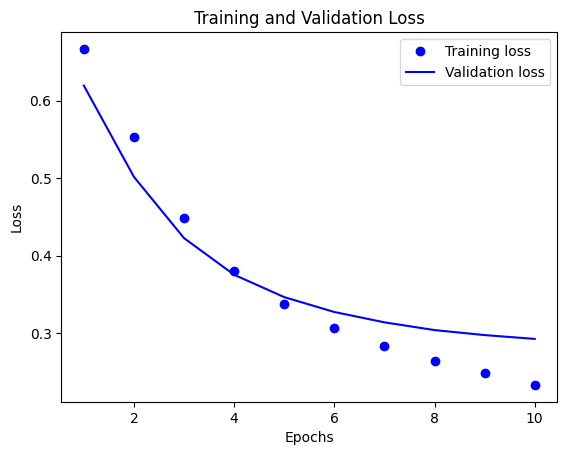

In [111]:
#PLOT OF LOSS
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

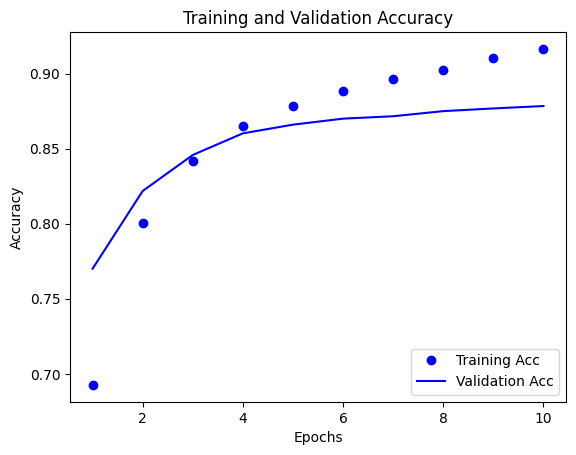

In [115]:
#PLOT OF ACCURACY
plt.plot(epochs,acc,'bo',label='Training Acc')
plt.plot(epochs,val_acc,'b',label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [118]:
# we can now integrate TextVectorization into the model so it can
# be used on raw string
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 6s 7ms/step - loss: 0.3104 - accuracy: 0.8733
0.8732799887657166


In [120]:
ex = ["The movie was good!", "The movie was bad!"]

export_model.predict(ex)

1/1 [==============================] - 0s 336ms/step


array([[0.5183666 ],
       [0.35166135]], dtype=float32)